In [4]:
import csv
from matplotlib import pyplot as plt
import numpy as np
from scipy.misc import imread
import pickle
import cv2
import seaborn as sns

In [5]:
%matplotlib inline
sns.set_context("poster")

In [388]:
# this file is used to process the raw output of recording training data from the simulator
# and prepare it for uploading to the AWS GPU

folder_to_process = "output"
print("Processing ", folder_to_process)


def extract_data(folder):
    X = [] #images
    XX = [] #senor data (aka speed in this case)
    y = [] #actual steering angles (throttle in the future)


    with open('output/_data.csv') as f:
        reader = csv.reader(f)

        for line in reader:
            #note bug in the original export that we need to add a 1 here
            #make sure in the next batch to remove this
            img_file_center = "{}_{}".format(int(line[0]) + 1,line[-1])

            X.append(imread('output/{}.jpg'.format(img_file_center)))
            XX.append([float(line[1])/100]) #throttle is -100 to 100
            y.append([float(line[2])/45]) # steering is -45 to 45

    return (np.array(X), np.array(XX), np.array(y))


X_train, XX_train, y_train = extract_data(folder_to_process)

print("--done--")

Processing  output
--done--


In [389]:
def pipeline(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)

#     # equalize the histogram of the Y channel
#     img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

#     # convert the YUV image back to RGB format
#     img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
#     print(img.shape)

    output = img[200:361,:,:]
    return  cv2.resize(output, (0,0), fx=0.5, fy=0.5)  

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


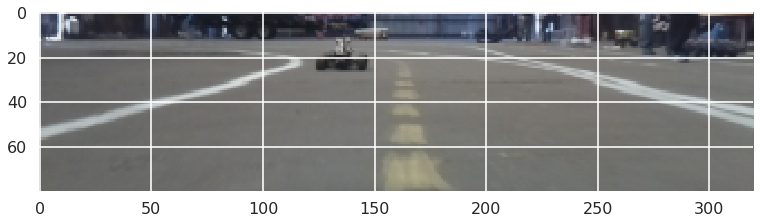

In [390]:
img = X_train[1000]
plt.imshow(pipeline(img))

In [391]:
# reduce image to the road section and apply any transforms in the pipeline
X_train = np.array([pipeline(x) for x in X_train])

In [238]:
# the following section was used to scrub through the video and find bad sections and remove them
current_frame = 870
scroll_rate = 20

Current Frame:  3690 Steering [ 0.11111111] Throttle [ 0.13]


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


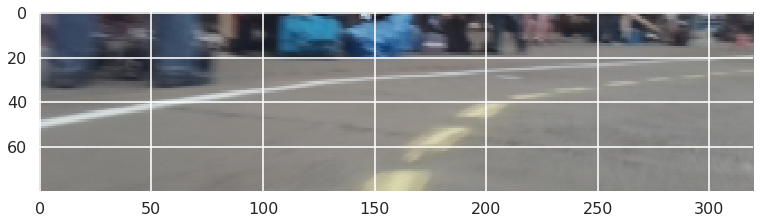

In [392]:
#scrub through thismanually for bad frames.... ouch time consuming
print("Current Frame: ", current_frame, "Steering", y_train[current_frame], "Throttle", XX_train[current_frame] )
plt.imshow(X_train[current_frame])
current_frame += scroll_rate



In [395]:
#drop bad frames
## bag 1
data_frames_to_drop = [(0,260)]


clean_indicies = np.ones(len(X_train))
for r in data_frames_to_drop:
    clean_indicies[r[0]:r[1]] = 0

In [396]:
X_cleaned = X_train[clean_indicies.astype(np.bool)]
XX_cleaned = XX_train[clean_indicies.astype(np.bool)]
y_cleaned = y_train[clean_indicies.astype(np.bool)]

print(X_cleaned.shape,XX_cleaned.shape, y_cleaned.shape)

data = {
    "images": X_train,
    "sensors": XX_train,
    "steering_throttle": y_train
}

(6401, 80, 320, 3) (6401, 1) (6401, 1)


In [397]:
with open('vector79_run_1.pkl', 'wb') as f:
    pickle.dump(data, f)
